In [40]:
import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join

from tqdm import tqdm

from datetime import date, time, datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import sys
#sys._enablelegacywindowsfsencoding()

import parser_stat

import matplotlib

%matplotlib inline

In [7]:
def choose_period(array, begin, end):
    less_index = array[:, 0] > datetime(2014, 9, 1, 0, 0)
    more_index = array[:, 0] < datetime(2014, 9, 30, 0, 0)

    return array[np.logical_and(less_index, more_index)]

In [8]:
def get_coords(begin_time, end_time, path_dir):
    lat_lon = np.zeros((0, 2))
    
    for path_file in tqdm(listdir(path_dir)):
        full_path_file = join(path_dir, path_file)
        
        if not isfile(full_path_file):
            continue
            
        date_obsr = datetime(*list(map(int, path_file.split('.')[0].split('_'))), 0, 0)
        
        if (date_obsr < begin_time) or (end_time < date_obsr):
            continue
            
        obsr_df = pd.read_csv(full_path_file) 
        obsr_df['time'] = obsr_df['time'].map(lambda x: datetime.combine(date_obsr, time(int(x.split(':')[0]), 0)))
        
        more = obsr_df['time'] >= begin_time
        less = obsr_df['time'] <= end_time
        valid_df = obsr_df[np.logical_and(more, less)]
        
        # temp for filter ion correction
        valid_df = valid_df[valid_df.Processing.str.contains("Ion. corr")]
        ##########################################
        
        lat_lon = np.vstack((lat_lon, valid_df[['Lat', 'Lon']]))
        
    return lat_lon

In [9]:
#read_lon_lat
def hurr_coords(path_dir):
    lat_lon = np.zeros((0, 2))
    
    for path_file in tqdm(listdir(path_dir)):
        full_path_file = join(path_dir, path_file)
        
        if not isfile(full_path_file):
            continue
                
        obsr_df = pd.read_csv(full_path_file, sep=',') 
        
        try: 
            obsr_df['TIME'] = obsr_df['TIME'].map(lambda x: datetime.strptime("2014/" + x, "%Y/%m/%d/%HZ"))
        except ValueError: 
            print ("Неправильная дата")
            continue
            
        #more = obsr_df['TIME'] >= begin_time
        #less = obsr_df['TIME'] <= end_time
        #valid_df = obsr_df[np.logical_and(more, less)]
        valid_df = obsr_df
            
        # temp for filter ion correction
        #valid_df = valid_df[valid_df.Processing.str.contains("Ion. corr")]
        ##########################################
        
        lat_lon = np.vstack((lat_lon, valid_df[['LAT', 'LON']]))
                
    return lat_lon

In [13]:
path_files = '..//data//__Results_2014//'
files =  [join(path_files, f) for f in listdir(path_files) if isfile(join(path_files, f))]

In [14]:
for path_file in tqdm(files):
    stat_df, geo_graph_df, coord_df, date_obs = parser_stat.parse_rocc(path_file)
    
    stat_df.to_csv('..//data//Result_py//Stat//' + date_obs + '.csv')
    geo_graph_df.to_csv('..//data//Result_py//Graph//' + date_obs + '.csv')
    coord_df.to_csv('..//data//Result_py//Coords//' + date_obs + '.csv', index=False)
    
    break

  0%|          | 0/365 [00:00<?, ?it/s]


In [15]:
path_stat_files = '..//data//Result_py//Stat//'
files_stat =  [join(path_stat_files, f) for f in listdir(path_stat_files) if isfile(join(path_stat_files, f))]

In [22]:
prob_total = []

for path_file in tqdm(files_stat):
    stat = pd.read_csv(path_file, index_col=0)
    date_obsr = date(*[int(x) for x in path_file.split('//')[-1].split('.')[0].split('_')])
    
    '''for i in range(24):
        time_obsr = datetime.combine(date_obsr, time(i, 0))
        el = stat.loc['Total'][i + 1]
        prob_total.append([time_obsr, el])
    '''
    
    prob_total.append([datetime.combine(date_obsr, time(0, 0)), stat.loc['Total'][0]])
    
prob_total = np.array(prob_total)

100%|██████████| 365/365 [00:00<00:00, 618.43it/s]


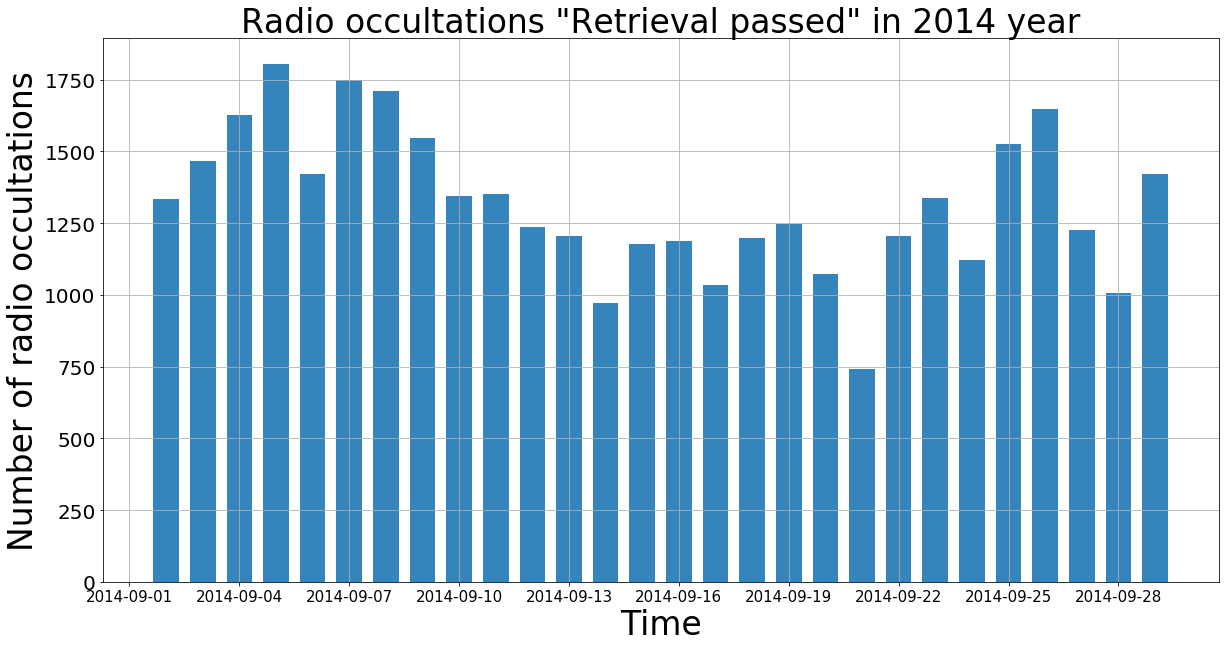

In [39]:
prob_local = choose_period(prob_total, datetime(2014, 1, 1, 0, 0), datetime(2014, 9, 30, 0, 0))

fig = plt.figure(figsize=(20, 10))

plt.bar(prob_local[:, 0], prob_local[:, 1], width=0.7, alpha=0.9)
plt.xlabel('Time', fontsize=33)
plt.ylabel('Number of radio occultations', fontsize=33)
plt.title('Radio occultations "Retrieval passed" in 2014 year', fontsize=33)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=20)
#matplotlib.rcParams.update({'font.size': 16})
plt.grid()
plt.show()

In [154]:
with open('Indeces.txt', 'r') as file:
    next(file)
    
    names = ['Year', 'DoY', 'Hour', 'Kp']
    indexes_df = pd.DataFrame(columns=names)
    
    count = 0
    for line in file:
        row = list(filter(lambda x: x != '', line.strip().split('\t')))
        
        indexes_df.loc[count] = [row[0], row[1], row[2], row[3]]
        count += 1
        

In [155]:
indexes_df.to_csv('kp.csv', index=False)

In [156]:
array_ae = []

for index, row in indexes_df.iterrows():
    # it's the worst
    str_time_ae = row[0] + '-' + row[1] + '-' + row[2]
    time_ae = datetime.strptime(str_time_ae, "%Y-%j-%H")
    
    array_ae.append([time_ae, int(row[3])])
    
array_ae = np.array(array_ae)

In [157]:
ae_local = choose_period(array_ae, datetime(2014, 9, 1, 0, 0), datetime(2014, 9, 30, 0, 0))

C:\Users\Ignatov K\Anaconda3\lib\site-packages\matplotlib\legend.py:623: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000000DFB81E6F60>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


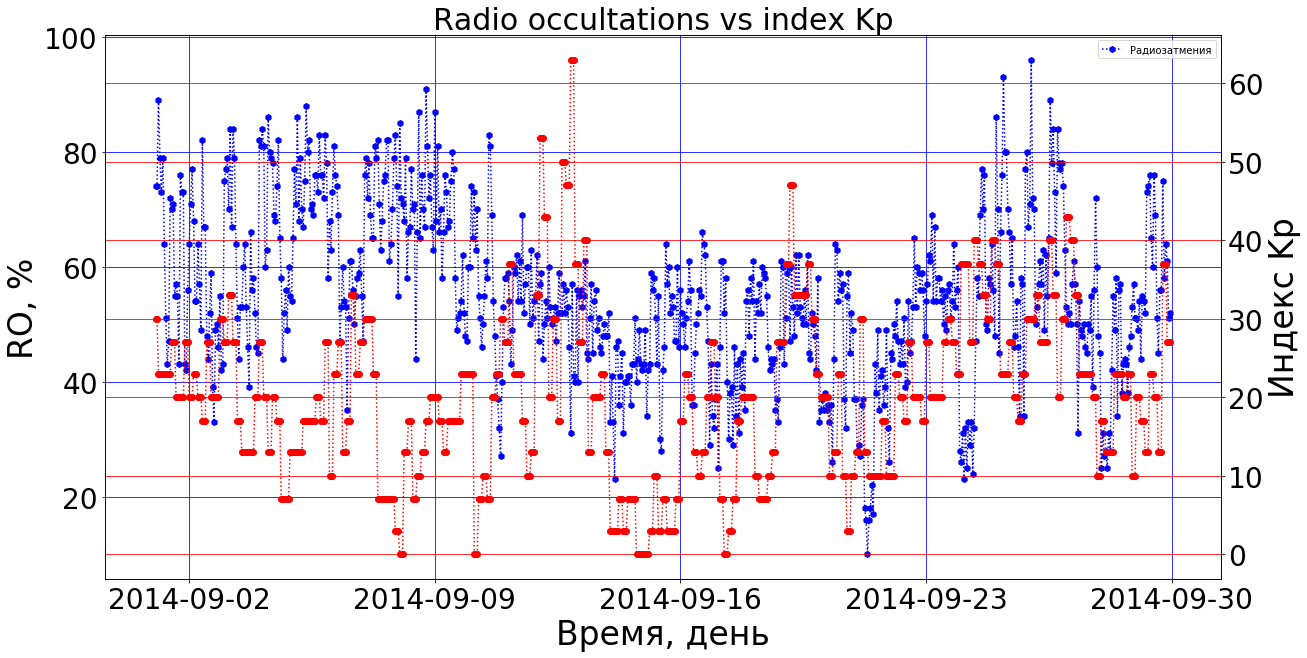

In [168]:
fig = plt.figure(figsize=(20, 10))

'''# multiply *6 !
plt.bar(prob_local[:, 0], prob_local[:, 1] * 6, width=0.05, alpha=0.9)
plt.plot(ae_local[:, 0], ae_local[:, 1], linewidth = 4, color='r')'''

ax_01 = plt.axes()
line_01, = ax_01.plot(prob_local[:, 0], prob_local[:, 1] , 'bh:')
#line_01 = ax_01.bar(prob_local[:, 0], prob_local[:, 1] * 6 , 'bh:')
#ax_01.axis([-0.04, 3.6, -0.01, 0.90])
ax_01.grid(color = 'b')
ax_01.plot(linewidth=4)

ax_01.set_xlabel(u'Время, день', fontsize = 33)
ax_01.set_ylabel(u'RO, %', fontsize = 33)
ax_01.set_title(u'Radio occultations vs index Kp', fontsize = 30)

ax_02 = ax_01.twinx()
line_02 = ax_02.plot(prob_local[:, 0], ae_local[:, 1], 'ro:')
ax_02.plot(linewidth = 4)
#ax_02.axis([-0.04, 3.6, 0.0, 800.0])
ax_02.set_ylabel(u'Индекс Kp', fontsize = 33)
ax_02.grid(color = 'r')
ax_02.legend((line_01, line_02), (u'Радиозатмения', u'Геомагнитный индекс'), loc = 'best')

plt.show()
plt.savefig('Occ_Kp.png', format = 'png')

In [14]:
path_coord_files = 'Result_py\\Coords\\'

begin_time = datetime(2014, 1, 1, 0, 0)
end_time = datetime(2014, 1, 5, 23, 59)

In [15]:
temp = get_coords(begin_time, end_time, path_coord_files)

100%|███████████████████████████████████████| 365/365 [00:00<00:00, 832.95it/s]


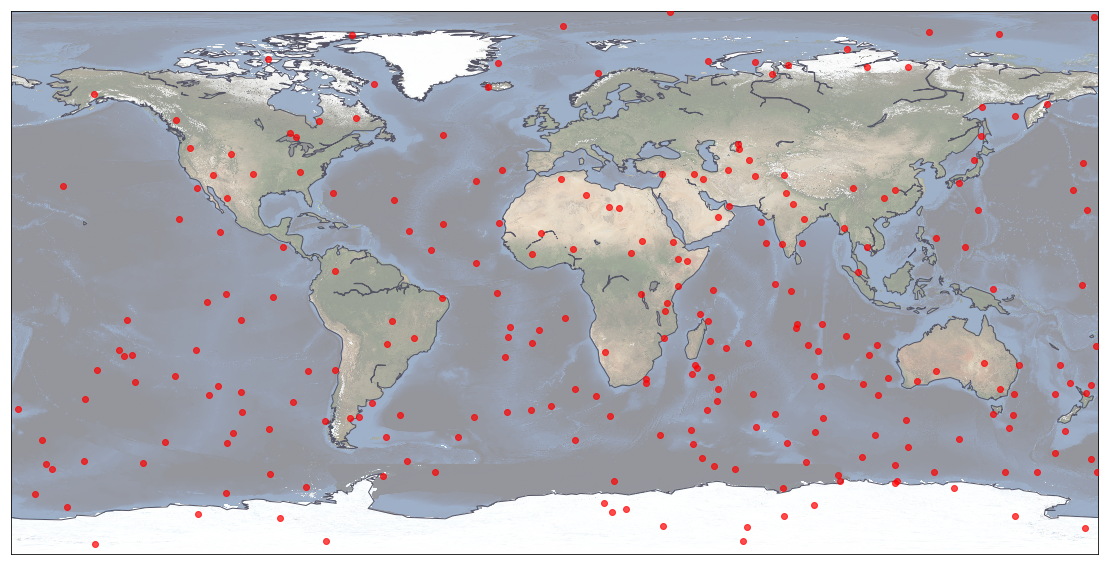

In [16]:
plt.figure(figsize=(20, 10))

earth = Basemap()
earth.bluemarble(alpha=0.42)
earth.drawcoastlines(color='#555566', linewidth=1)

#plt.scatter(lngs, lats, mags, c='red',alpha=0.5, zorder=10)
plt.scatter(temp[:, 1], temp[:, 0], c='red', alpha=0.7, zorder = 10)

In [17]:
#Hurricanes
path_files = '__Named'
files =  [join(path_files, f) for f in listdir(path_files) if isfile(join(path_files, f))]

In [18]:
for path_file in tqdm(files):
    hurr_df = parser_stat.parse_hurricane(path_file)
    hurr_df.to_csv("Result_py\\Hurricane\\" + path_file.split('\\')[-1].split('.')[0].lower() + ".csv", index=False, sep=',')


100%|██████████████████████████████████████████| 78/78 [00:14<00:00,  5.24it/s]


In [20]:
path_hurr_files = 'Result_py\\Hurricane\\'
begin_time = datetime(2014, 1, 1, 0, 0)
end_time = datetime(2014, 1, 5, 23, 59)

In [43]:
temp1 = hurr_coords(path_hurr_files)

  0%|                                                   | 0/78 [00:00<?, ?it/s]

Неправильная дата


 67%|████████████████████████████              | 52/78 [00:00<00:00, 81.13it/s]

Неправильная дата


100%|██████████████████████████████████████████| 78/78 [00:00<00:00, 82.16it/s]
